In [47]:
# Access the whole dataset and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

glucose_df = pd.read_csv('glucose.csv')
phases_df = pd.read_csv('hormones_and_selfreport.csv')
# This one will not simplify to the phase, but we will predict using the hormones themselves

In [48]:

glucose_df.loc[glucose_df['glucose_value'] > 15, 'glucose_value'] *= 0.05556  # convert mg/dL to mmol/L
glucose_df[glucose_df['glucose_value'] > 15 ]

glist = (glucose_df
         .groupby(["id", "study_interval", "day_in_study"], as_index=False)
         .agg(glucose_values=("glucose_value", list))
        )

glist["glucose_times"] = (glucose_df
    .groupby(["id", "study_interval", "day_in_study"])["timestamp"]
    .agg(list)
    .values
)

combined = phases_df.merge(
    glist,
    on=["id", "study_interval", "day_in_study"],
    how="left"
)


In [49]:
long_df = combined.explode(['glucose_times', 'glucose_values']).reset_index(drop=True)
long_df["glucose_values"] = pd.to_numeric(long_df["glucose_values"], errors="coerce")
hormones = ['lh','estrogen','pdg']
simple_df = long_df[['id', 'day_in_study', 'phase', 'glucose_values', 'glucose_times', 'lh', 'estrogen', 'pdg']].copy()
simple_df.head(10)# pdg is missing from everything

,id,day_in_study,phase,glucose_values,glucose_times,lh,estrogen,pdg
0,1,1,Follicular,4.9,00:04:06,2.9,94.2,NaN
1,1,1,Follicular,5.0,00:09:06,2.9,94.2,NaN
2,1,1,Follicular,5.1,00:14:07,2.9,94.2,NaN
3,1,1,Follicular,5.1,00:19:06,2.9,94.2,NaN
4,1,1,Follicular,5.1,00:24:06,2.9,94.2,NaN
5,1,1,Follicular,5.2,00:29:06,2.9,94.2,NaN
6,1,1,Follicular,5.3,00:34:07,2.9,94.2,NaN
7,1,1,Follicular,5.3,00:39:07,2.9,94.2,NaN
8,1,1,Follicular,5.3,00:44:07,2.9,94.2,NaN
9,1,1,Follicular,4.9,00:49:06,2.9,94.2,NaN


In [50]:
import numpy as np
import pandas as pd

# -----------------------
# Helpers / Preprocessing
# -----------------------
def _to_minutes(t):
    """Convert HH:MM:SS string to minutes since midnight."""
    if pd.isna(t): return np.nan
    h, m, s = map(int, str(t).split(":"))
    return h*60 + m + s/60.0

def prepare_glucose(df):
    """
    Ensure required columns and sorted sampling.
    Adds: minutes (float, minutes since midnight).
    """
    req = {"id", "day_in_study", "phase", "glucose_values", "glucose_times"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    out = df.copy()
    out["minutes"] = out["glucose_times"].map(_to_minutes)
    out = out.dropna(subset=["minutes", "glucose_values"])
    out = out.sort_values(["id", "day_in_study", "minutes"])
    return out

# -----------------------
# 1) Overnight basal glucose
# -----------------------
def overnight_basal(df, start="03:00:00", end="05:00:00"):
    start_min = _to_minutes(start)
    end_min   = _to_minutes(end)
    subset = df[(df["minutes"] >= start_min) & (df["minutes"] < end_min)]
    grp = (subset
           .groupby(["id", "day_in_study", "phase"], as_index=False)
           .agg(overnight_mean=("glucose_values", "mean"),
                overnight_median=("glucose_values", "median"),
                n_points=("glucose_values", "size")))
    return grp

# -----------------------
# 2) Variability: SD, CV, MAGE
# -----------------------
def _local_extrema(values):
    """
    Simple local maxima/minima indices (exclude endpoints).
    """
    v = np.asarray(values, dtype=float)
    idx = np.arange(1, len(v)-1)
    peaks  = idx[(v[1:-1] > v[:-2]) & (v[1:-1] > v[2:])]
    trough = idx[(v[1:-1] < v[:-2]) & (v[1:-1] < v[2:])]
    return peaks, trough

def _mage(values, threshold=None):
    """
    Mean Amplitude of Glycemic Excursions:
    - Identify alternating peaks & troughs.
    - Keep excursions with amplitude >= threshold.
    - Default threshold = SD of the series (classic definition).
    """
    v = np.asarray(values, dtype=float)
    if len(v) < 5 or np.allclose(v.std(ddof=1), 0):
        return np.nan
    if threshold is None:
        threshold = np.nanstd(v, ddof=1)

    peaks, trough = _local_extrema(v)
    all_ext = np.sort(np.concatenate([peaks, trough]))
    if all_ext.size < 2:
        return np.nan

    amps = []
    last = None
    for i in all_ext:
        if last is None:
            last = i
            continue
        amp = abs(v[i] - v[last])
        if amp >= threshold:
            amps.append(amp)
            last = i
    return float(np.mean(amps)) if amps else np.nan

def variability_metrics(df):
    """
    Daily SD, CV, and MAGE per id/day/phase.
    """
    def _cv(x):
        m = np.mean(x)
        return np.std(x, ddof=1)/m if m and not np.isclose(m, 0) else np.nan

    def _mage_wrap(x):
        return _mage(np.asarray(x, dtype=float))

    grp = (df.groupby(["id", "day_in_study", "phase"], as_index=False)
             .agg(mean_glucose=("glucose_values", "mean"),
                  sd_glucose=("glucose_values", lambda x: np.std(x, ddof=1)),
                  cv_glucose=("glucose_values", _cv),
                  mage=("glucose_values", _mage_wrap),
                  n_points=("glucose_values", "size")))
    return grp

# -----------------------
# 3) Postprandial response (ΔAUC 0–120 min)
# -----------------------
def _nearest_at_time(min_series, val_series, t_min):
    """Return glucose closest in time to t_min."""
    idx = (min_series - t_min).abs().idxmin()
    return val_series.loc[idx]

def infer_meal_times(df_day, rise_thresh=1, horizon_min=15):
    """
    Heuristic to infer meal starts: find times where glucose rises by >= rise_thresh
    within 'horizon_min' minutes. Returns candidate start times (minutes).
    """
    m = df_day["minutes"].to_numpy()
    g = df_day["glucose_values"].to_numpy()
    starts = []
    j = 0
    for i in range(len(m)):
        # look ahead within horizon
        while j < len(m) and m[j] - m[i] <= horizon_min:
            j += 1
        if j > i + 1:
            if (g[j-1] - g[i]) >= rise_thresh:
                starts.append(m[i])
    # de-duplicate nearby starts (>= 60 min apart)
    starts = sorted(starts)
    dedup = []
    for t in starts:
        if not dedup or (t - dedup[-1] >= 60):
            dedup.append(t)
    return dedup

def postprandial_auc(df, meal_times_df=None, window_min=60, baseline_window=15):
    """
    Average ΔAUC 0–window_min after meals (per id/day/phase).
    If meal_times_df is None, infer meals from rises.
    meal_times_df columns (optional): id, day_in_study, meal_minute
    """
    out = []
    for (pid, day, ph), gdf in df.groupby(["id", "day_in_study", "phase"]):
        gdf = gdf.sort_values("minutes")
        mins = gdf["minutes"]
        vals = gdf["glucose_values"]

        if meal_times_df is not None:
            mt = (meal_times_df[(meal_times_df["id"] == pid) &
                                (meal_times_df["day_in_study"] == day)]
                  ["meal_minute"].tolist())
        else:
            mt = infer_meal_times(gdf)

        aucs = []
        for t0 in mt:
            # baseline = average in [t0 - baseline_window, t0)
            base_seg = gdf[(mins >= (t0 - baseline_window)) & (mins < t0)]
            if base_seg.empty:
                base = _nearest_at_time(mins, vals, t0)
            else:
                base = base_seg["glucose_values"].mean()

            # gather samples up to t0 + window_min
            seg = gdf[(mins >= t0) & (mins <= t0 + window_min)]
            if seg.shape[0] < 2:
                continue
            delta = seg["glucose_values"].to_numpy() - base
            # trapezoidal AUC of positive deltas only
            t_rel = seg["minutes"].to_numpy() - t0
            delta = np.maximum(delta, 0.0)
            auc = np.trapz(delta, t_rel)
            aucs.append(auc)

        out.append({
            "id": pid, "day_in_study": day, "phase": ph,
            "pp_auc_0_120": np.mean(aucs) if aucs else np.nan,
            "n_meals": len(aucs)
        })
    return pd.DataFrame(out)

# -----------------------
# 4) Decay slope k after peaks (glucose clearance)
# -----------------------
def decay_slope_k(df, look_forward_min=120, floor_eps=1.0):
    """
    For each detected peak, fit G(t) ~ G_baseline + A*exp(-k t) over the fall.
    We estimate k by linear reg on ln(G - baseline) vs time (only decreasing part).
    Returns per id/day/phase median k.
    """
    rows = []
    for (pid, day, ph), gdf in df.groupby(["id", "day_in_study", "phase"]):
        gdf = gdf.sort_values("minutes")
        m = gdf["minutes"].to_numpy()
        g = gdf["glucose_values"].to_numpy()

        if len(g) < 6:
            rows.append({"id": pid, "day_in_study": day, "phase": ph, "k_decay": np.nan, "n_events": 0})
            continue

        # find simple peaks
        peaks = np.where((g[1:-1] > g[:-2]) & (g[1:-1] > g[2:]))[0] + 1
        ks = []
        for p in peaks:
            t0 = m[p]
            # window after peak
            mask = (m > t0) & (m <= t0 + look_forward_min)
            if mask.sum() < 3:
                continue
            t_seg = m[mask] - t0

            # estimate "baseline" as min in the following 2 hours
            base = np.min(g[mask])
            y = g[mask] - base
            y = np.where(y < floor_eps, np.nan, y)  # avoid log(<=0)
            if np.isnan(y).sum() > (len(y) - 3):
                continue
            # keep only strictly decreasing region vs prior sample (rough heuristic)
            dec_mask = np.diff(np.r_[g[p], g[mask]]) <= 0
            if dec_mask.sum() < 3:
                continue
            t_fit = t_seg[dec_mask]
            y_fit = y[dec_mask]
            y_fit = y_fit[~np.isnan(y_fit)]
            t_fit = t_fit[:len(y_fit)]

            if len(y_fit) < 3:
                continue
            # linear regression on ln(y) = ln(A) - k t
            x = t_fit
            z = np.log(y_fit)
            k = -np.polyfit(x, z, 1)[0]
            if np.isfinite(k) and k > 0:
                ks.append(k)

        rows.append({
            "id": pid, "day_in_study": day, "phase": ph,
            "k_decay": np.median(ks) if ks else np.nan,
            "n_events": len(ks)
        })
    return pd.DataFrame(rows)


In [71]:
# =======================
# EXAMPLE PIPELINE / USE
# =======================
# df_gluc: your dataframe for one or many participants with columns:
# ['id','day_in_study','phase','glucose_values','glucose_times']

# 0) prepare
# df_gluc = <your dataframe>
df_ready = prepare_glucose(simple_df)
df_ready = df_ready[(df_ready["minutes"] >= 9*60) & (df_ready["minutes"] < 21*60)]
# Display sample of df_ready to ensure it's only daytime data now
df_ready.head()


# 1) Overnight basal
overnight_df = overnight_basal(df_ready, start="03:00:00", end="05:00:00")

# 2) Variability
var_df = variability_metrics(df_ready)

# 3) Postprandial AUC (uses inferred meals by default; pass a meal_times_df if you have real meals)
pp_df = postprandial_auc(df_ready, meal_times_df=None, window_min=60, baseline_window=15)

# 4) Decay slope k
k_df = decay_slope_k(df_ready, look_forward_min=120, floor_eps=1.0)

# Merge all daily/phase metrics (left join on the intersection keys)
metrics = (overnight_df
           .merge(var_df, on=["id","day_in_study","phase"], how="outer")
           .merge(pp_df,   on=["id","day_in_study","phase"], how="outer")
           .merge(k_df,    on=["id","day_in_study","phase"], how="outer"))

# Now you can aggregate by phase or within-subject:
by_phase = (metrics
            .groupby(["id","phase"], as_index=False)
            .agg(overnight_mean=("overnight_mean", "mean"),
                 cv_glucose=("cv_glucose","mean"),
                 mage=("mage", "mean"),
                 pp_auc_0_120=("pp_auc_0_120", "mean"),
                 k_decay=("k_decay","mean")))


In [72]:
# Display final metrics
pp_df.head(100)
# check nans in pp_df for pp_auc_0_120
print(pp_df.isna().sum())
print(pp_df.shape[0])

# In a second iteration, let's increase our n by calculating this for each day, id, and phase, as opposed to averaging over days first.
#print(df_ready.head(10))

id                0
day_in_study      0
phase             0
pp_auc_0_120    134
n_meals           0
dtype: int64
3073


In [73]:
# Now using by phase, we'll group and compute statistics like averages, stddev, etc.
# We want the average of each metric by phase


average_values = by_phase.groupby('phase')[['overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_120', 'k_decay']].mean()
print(average_values)
# Now calculate standard deviations
std_values = by_phase.groupby('phase')[['overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_120', 'k_decay']].std()
print(std_values)

            overnight_mean  cv_glucose      mage  pp_auc_0_120   k_decay
phase                                                                   
Fertility              NaN    0.143492  1.817609     66.123579  0.012544
Follicular             NaN    0.149460  1.858763     62.900467  0.013324
Luteal                 NaN    0.142217  1.794472     65.211938  0.012864
Menstrual              NaN    0.143331  1.838986     64.140105  0.012955
            overnight_mean  cv_glucose      mage  pp_auc_0_120   k_decay
phase                                                                   
Fertility              NaN    0.030402  0.425306     14.829226  0.003348
Follicular             NaN    0.028189  0.409987     13.283313  0.003761
Luteal                 NaN    0.031339  0.429467     13.711243  0.002754
Menstrual              NaN    0.027133  0.478532     12.889264  0.004028


In [74]:
# === Daily per-person metrics and a daily "Cremaster Score" ===
# Assumes you already defined the helper functions from earlier:
# prepare_glucose, overnight_basal, variability_metrics, postprandial_auc, decay_slope_k

import numpy as np
import pandas as pd



# 0) Prepare raw glucose rows
# df_gluc = <your dataframe with columns: ['id','day_in_study','phase','glucose_values','glucose_times']>
df_ready = prepare_glucose(simple_df)  # adds 'minutes', sorts, etc.

# (optional) daily glucose summary (mean/min/max per day)
daily_glucose = (df_ready
    .groupby(['id','day_in_study','phase'], as_index=False)
    .agg(
        daily_mean_glucose = ('glucose_values', 'mean'),
        daily_min_glucose  = ('glucose_values', 'min'),
        daily_max_glucose  = ('glucose_values', 'max'),
        n_points           = ('glucose_values', 'size')
    )
)

# 1) Compute the four signals PER DAY PER PERSON (these already return daily grain)
overnight_df = overnight_basal(df_ready, start="03:00:00", end="05:00:00")            # overnight_mean/median
var_df       = variability_metrics(df_ready)                                          # mean_glucose, sd, CV, MAGE
pp_df        = postprandial_auc(df_ready, meal_times_df=None, window_min=60)         # pp_auc_0_120
k_df         = decay_slope_k(df_ready, look_forward_min=120, floor_eps=1.0)           # k_decay

# 2) Merge into ONE daily table
daily_metrics = (
    daily_glucose
      .merge(overnight_df, on=['id','day_in_study','phase'], how='left')
      .merge(var_df,       on=['id','day_in_study','phase'], how='left')
      .merge(pp_df,        on=['id','day_in_study','phase'], how='left')
      .merge(k_df,         on=['id','day_in_study','phase'], how='left')
)

# 3) Build a DAILY "Cremaster Score"
#    Higher insulin resistance is reflected by: higher overnight_mean, higher CV, higher MAGE, higher postprandial AUC.
#    Faster clearance (k_decay) is *protective* → subtract it.
score_components = {
    'overnight_mean',    # from overnight_basal
    'cv_glucose',        # from variability_metrics
    'mage',              # from variability_metrics
    'pp_auc_0_120',      # from postprandial_auc
    'k_decay'            # from decay_slope_k (protective)
}

# Ensure columns exist; if some are missing due to sparse data, fill NaN (they’ll drop in z-scores)
for c in score_components:
    if c not in daily_metrics.columns:
        daily_metrics[c] = np.nan

# --- Option A (recommended): within-person normalization (z-scores per id) ---
def z_within_id(s):
    mu = s.mean()
    sd = s.std(ddof=1)
    return (s - mu) / sd if pd.notnull(sd) and sd > 0 else s * np.nan

norm = (daily_metrics
        .groupby('id', group_keys=False)
        .apply(lambda g: g.assign(
            z_overnight = z_within_id(g['overnight_mean']),
            z_cv        = z_within_id(g['cv_glucose']),
            z_mage      = z_within_id(g['mage']),
            z_ppauc     = z_within_id(g['pp_auc_0_120']),
            z_k         = z_within_id(g['k_decay'])
        ))
)

# Equal weights (tune if you want)
norm['cremaster_score_daily'] = (
    + norm['z_overnight']
    + norm['z_cv']
    + norm['z_mage']
    + norm['z_ppauc']
    - norm['z_k']            # subtract: higher k = better clearance
)

daily_scores_within = norm[['id','day_in_study','phase',
                            'daily_mean_glucose','daily_min_glucose','daily_max_glucose','n_points',
                            'overnight_mean','cv_glucose','mage','pp_auc_0_120','k_decay',
                            'cremaster_score_daily']].copy()

# --- Option B: population-level normalization (if you prefer global z-scores) ---
pop = daily_metrics.copy()
def z_global(x): 
    sd = x.std(ddof=1)
    return (x - x.mean())/sd if pd.notnull(sd) and sd > 0 else x * np.nan

for src, dst in [('overnight_mean','Z_overnight'),
                 ('cv_glucose',   'Z_cv'),
                 ('mage',         'Z_mage'),
                 ('pp_auc_0_120', 'Z_ppauc'),
                 ('k_decay',      'Z_k')]:
    pop[dst] = z_global(pop[src])

pop['cremaster_score_daily_global'] = (
    + pop['Z_overnight'] + pop['Z_cv'] + pop['Z_mage'] + pop['Z_ppauc'] - pop['Z_k']
)

daily_scores_global = pop[['id','day_in_study','phase',
                           'daily_mean_glucose','daily_min_glucose','daily_max_glucose','n_points',
                           'overnight_mean','cv_glucose','mage','pp_auc_0_120','k_decay',
                           'cremaster_score_daily_global']].copy()

# 4) Use either `daily_scores_within` (within-person) or `daily_scores_global` (population) downstream.
print("Daily rows (within-person scoring):", len(daily_scores_within))
print(daily_scores_within.head(10))


Daily rows (within-person scoring): 3108
   id  day_in_study       phase  daily_mean_glucose  daily_min_glucose  \
0   1             1  Follicular            5.498958                3.7   
1   1             2  Follicular            5.372222                3.9   
2   1             3  Follicular            5.579514                3.7   
3   1             4   Fertility            5.206597                4.2   
4   1             5   Fertility            5.381597                4.2   
5   1             6   Fertility            5.310069                4.4   
6   1             7   Fertility            5.343403                4.5   
7   1             8   Fertility            5.185764                4.3   
8   1             9   Fertility            5.629514                4.0   
9   1            10      Luteal            5.037165                2.6   

   daily_max_glucose  n_points  overnight_mean  cv_glucose      mage  \
0                7.4       288        5.337500    0.119133  1.508333   


   id  day_in_study       phase  daily_mean_glucose  daily_min_glucose  \
0   1             1  Follicular            5.498958                3.7   
1   1             2  Follicular            5.372222                3.9   
2   1             3  Follicular            5.579514                3.7   
3   1             4   Fertility            5.206597                4.2   
4   1             5   Fertility            5.381597                4.2   
5   1             6   Fertility            5.310069                4.4   
6   1             7   Fertility            5.343403                4.5   
7   1             8   Fertility            5.185764                4.3   
8   1             9   Fertility            5.629514                4.0   
9   1            10      Luteal            5.037165                2.6   

   daily_max_glucose  n_points  overnight_mean  cv_glucose      mage  \
0                7.4       288        5.337500    0.119133  1.508333   
1                7.2       288        5.7

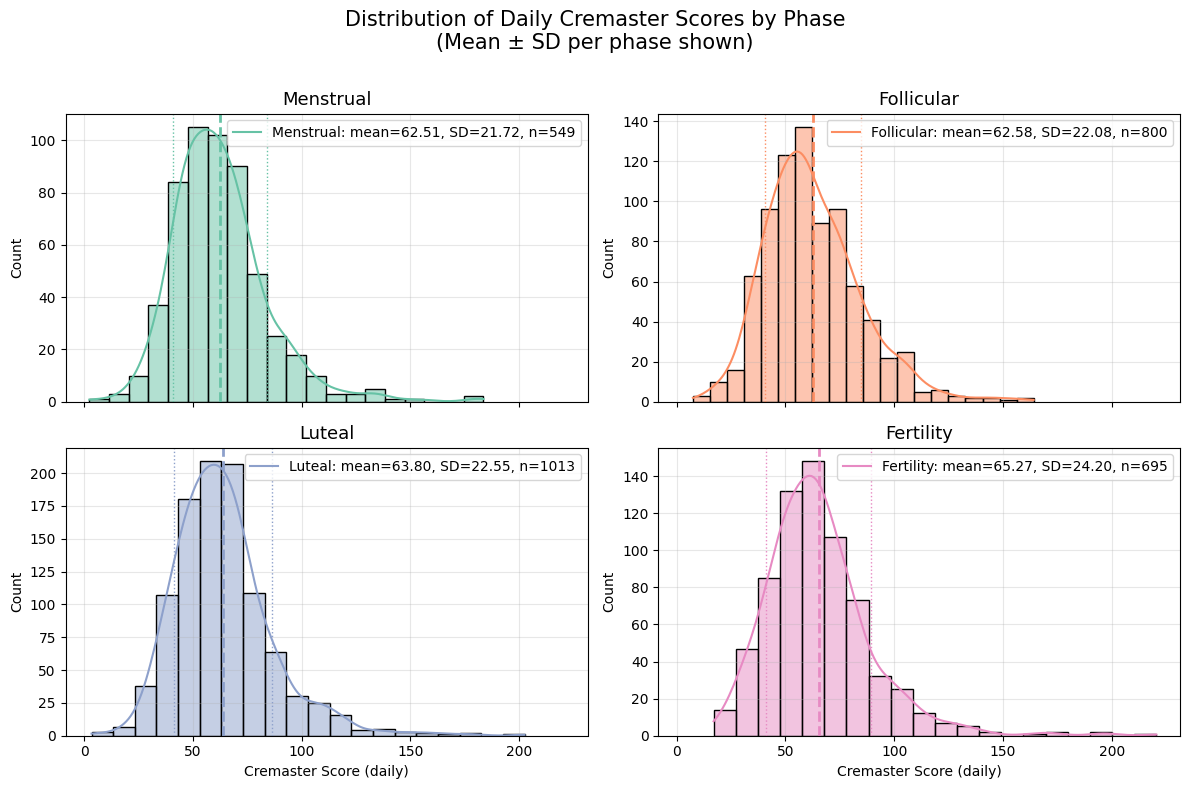


Per-phase summary:


,phase,mean,std,count,mean_std
3,Menstrual,62.510391,21.723296,549,62.51 ± 21.723
1,Follicular,62.575703,22.081530,800,62.576 ± 22.082
2,Luteal,63.802885,22.552716,1013,63.803 ± 22.553
0,Fertility,65.273057,24.204849,695,65.273 ± 24.205


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Choose dataset and score column
df_plot = daily_scores_within.copy()    # or daily_scores_global
print(daily_scores_within.head(10))
# print column headers of daily_scores_within
# ['id', 'day_in_study', 'phase', 'daily_mean_glucose', 'daily_min_glucose', 'daily_max_glucose', 'n_points', 
# 'overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_120', 'k_decay', 'cremaster_score_daily']
score_col = 'pp_auc_0_120'     # or 'cremaster_score_daily_global'
phase_col = 'phase'

# Compute phase-wise stats
phase_stats = (
    df_plot.groupby(phase_col)[score_col]
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .sort_values('mean', ascending=True)
)

# Determine subplot layout
phases = phase_stats[phase_col].tolist()
n_phases = len(phases)
cols = 2
rows = math.ceil(n_phases / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True)
axes = axes.flatten()

palette = sns.color_palette('Set2', n_phases)

for i, (phase, row) in enumerate(phase_stats.set_index(phase_col).iterrows()):
    ax = axes[i]
    subset = df_plot[df_plot[phase_col] == phase][score_col].dropna()
    
    # Plot histogram
    sns.histplot(subset, bins=20, kde=True, color=palette[i], alpha=0.5, ax=ax)
    
    # Add vertical lines for mean ± SD
    ax.axvline(row['mean'], color=palette[i], linestyle='--', linewidth=2)
    ax.axvline(row['mean'] + row['std'], color=palette[i], linestyle=':', linewidth=1)
    ax.axvline(row['mean'] - row['std'], color=palette[i], linestyle=':', linewidth=1)
    
    # Title and legend
    ax.set_title(f"{phase}", fontsize=13)
    ax.set_xlabel("Cremaster Score (daily)")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)
    
    # Legend with mean ± SD and count
    ax.legend(
        [f"{phase}: mean={row['mean']:.2f}, SD={row['std']:.2f}, n={int(row['count'])}"],
        loc="upper right",
        frameon=True
    )

# Remove unused axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Daily Cremaster Scores by Phase\n(Mean ± SD per phase shown)", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Optional summary table
print("\nPer-phase summary:")
display(phase_stats.assign(mean_std=lambda d: d['mean'].round(3).astype(str) + " ± " + d['std'].round(3).astype(str)))


In [76]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

# pick the metric you want to test (replace with others to loop)
metric = 'pp_auc_0_120'  # or 'cremaster_score_daily'
df = daily_scores_within.copy()

# ensure each subject has at least one value per phase
pivot = df.pivot_table(index='id', columns='phase', values=metric, aggfunc='mean')

# drop subjects with missing phase data (required for repeated-measures)
pivot = pivot.dropna(axis=0)

print(f"\nSubjects included: {pivot.shape[0]}")
print(f"Phases compared: {list(pivot.columns)}")

# -----------------------------
# Option 1: Friedman test (non-parametric)
# -----------------------------
if pivot.shape[1] >= 3:
    stat, p = friedmanchisquare(*[pivot[c] for c in pivot.columns])
    print(f"\nFriedman test for {metric}: χ²={stat:.3f}, p={p:.4e}")
else:
    print("\nNeed ≥3 phases for Friedman test; use paired t-test if only two.")

# -----------------------------
# Option 2: Repeated Measures ANOVA (parametric)
# -----------------------------
long_df = pivot.reset_index().melt(id_vars='id', var_name='phase', value_name=metric)
anova = AnovaRM(long_df, depvar=metric, subject='id', within=['phase']).fit()
print("\nRepeated-Measures ANOVA results:")
print(anova)

# -----------------------------
# Post-hoc pairwise comparisons (Tukey or paired t-tests)
# -----------------------------
from scipy.stats import ttest_rel
phases = list(pivot.columns)
pairs = list(combinations(phases, 2))

print("\nPairwise (paired) t-tests with Bonferroni correction:")
alpha = 0.05 / len(pairs)
for a, b in pairs:
    tstat, pval = ttest_rel(pivot[a], pivot[b], nan_policy='omit')
    signif = "⭐" if pval < alpha else ""
    print(f"{a} vs {b}: t={tstat:.3f}, p={pval:.4e} {signif}")



Subjects included: 41
Phases compared: ['Fertility', 'Follicular', 'Luteal', 'Menstrual']

Friedman test for pp_auc_0_120: χ²=6.746, p=8.0438e-02

Repeated-Measures ANOVA results:
               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
phase  2.4698 3.0000 120.0000 0.0652


Pairwise (paired) t-tests with Bonferroni correction:
Fertility vs Follicular: t=2.952, p=5.2610e-03 ⭐
Fertility vs Luteal: t=1.644, p=1.0794e-01 
Fertility vs Menstrual: t=1.706, p=9.5704e-02 
Follicular vs Luteal: t=-1.542, p=1.3089e-01 
Follicular vs Menstrual: t=-0.766, p=4.4838e-01 
Luteal vs Menstrual: t=0.466, p=6.4339e-01 


In [77]:
# Now looking at phase stats, see if there is correlation between calculated glucose metrics and hormone levels
# Specifically, calculate correlation between pp_auc_0_120 and each hormone levels on that day

metric = 'pp_auc_0_120'  # or 'cremaster_score_daily'
hormone_cols = ['lh', 'estrogen', 'pdg']
phase_metrics = daily_scores_within.merge(
    simple_df[['id', 'day_in_study'] + hormone_cols].drop_duplicates(),
    on=['id', 'day_in_study'],
    how='left'
)
correlations = {}
for hormone in hormone_cols:
    valid = phase_metrics[[metric, hormone]].dropna()
    if not valid.empty:
        corr = valid[metric].corr(valid[hormone])
        correlations[hormone] = corr
    else:
        correlations[hormone] = np.nan
print("\nCorrelations between Cremaster Score and Hormone Levels:")
for hormone, corr in correlations.items():
    print(f"{hormone}: correlation = {corr:.3f}")
print(phase_metrics.columns)



Correlations between Cremaster Score and Hormone Levels:
lh: correlation = 0.065
estrogen: correlation = 0.047
pdg: correlation = nan
Index(['id', 'day_in_study', 'phase', 'daily_mean_glucose',
       'daily_min_glucose', 'daily_max_glucose', 'n_points', 'overnight_mean',
       'cv_glucose', 'mage', 'pp_auc_0_120', 'k_decay',
       'cremaster_score_daily', 'lh', 'estrogen', 'pdg'],
      dtype='object')


POST-EZEKIEL Brain-dump

1. First, there are many statistical tests that solve the problems you're convoluting. Cox test, finding a hazard ratio, etc
2. LLM's and AI should be tried either to evaluate, validate, or as a direct analysis of the time-series
3. You have WAY more power, predicting using the direct hormonal data. That increases the power and the likelihood that you will find a part of the phase "correlation between hormones and these 
4. Consider how you normalize to a baseline, within patient hormonal levels or within-paitnet
5. This also lends to the idea of a z-score. How can you calculate which days or periods are anomalous?
6. Look at demographic data/BMI/anything that got a high feature importance score in google paper
    - Some participants entered height and weight! ~25/50






In [78]:
# Calculate BMI from height/weight function
def calculate_bmi(weight_kg, height_cm):
    height_m = height_cm / 100.0
    bmi = weight_kg / (height_m ** 2)
    return bmi
# Extract from height_and_weight.csv
height_weight_df = pd.read_csv('height_and_weight.csv')
height_weight_df['bmi_2022'] = height_weight_df.apply(lambda row: calculate_bmi(row['weight_2022'], row['height_2022']), axis=1)
height_weight_df['bmi_2024'] = height_weight_df.apply(lambda row: calculate_bmi(row['weight_2024'], row['height_2024']), axis=1)
# Return bmi column with id
bmi_df = height_weight_df[['id', 'bmi_2022', 'bmi_2024']].copy()
print(bmi_df.head(50))

    id   bmi_2022   bmi_2024
0    1        NaN        NaN
1    2        NaN        NaN
2    3  18.645344        NaN
3    4  26.989619        NaN
4    6        NaN        NaN
5    7  19.377163        NaN
6    8        NaN        NaN
7    9  19.843750  20.898437
8   10  23.554687        NaN
9   11        NaN        NaN
10  12        NaN  24.977043
11  13        NaN        NaN
12  14  17.171758        NaN
13  15  20.000000        NaN
14  16        NaN        NaN
15  18        NaN  20.882756
16  19  19.740400        NaN
17  20        NaN        NaN
18  22        NaN        NaN
19  23        NaN        NaN
20  24  33.203125        NaN
21  26  21.967120  28.911565
22  27        NaN        NaN
23  29        NaN        NaN
24  30        NaN  30.552281
25  32  22.196609        NaN
26  33  29.892921        NaN
27  34  18.343232        NaN
28  37  24.218750        NaN
29  38        NaN  25.086505
30  39        NaN        NaN
31  40        NaN        NaN
32  41  28.040378        NaN
33  42        

In [79]:
# WITHIN-PATIENT ANALYSIS: Focus on individual variability patterns
# This approach is more powerful because it controls for individual baseline differences

import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.anova import AnovaRM
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_within_patient_changes(df, metric='pp_auc_0_120'):
    """
    Analyze within-patient changes across menstrual phases.
    Returns individual patient deltas and statistical tests.
    """
    
    # 1. Calculate within-patient phase differences
    pivot = df.pivot_table(index='id', columns='phase', values=metric, aggfunc='mean')
    pivot = pivot.dropna(axis=0)  # Only patients with all phases
    
    print(f"=== WITHIN-PATIENT ANALYSIS FOR {metric.upper()} ===")
    print(f"Patients with complete phase data: {pivot.shape[0]}")
    print(f"Phases analyzed: {list(pivot.columns)}\n")
    
    # 2. Calculate pairwise differences for each patient
    phases = list(pivot.columns)
    within_patient_deltas = {}
    
    for i, phase_a in enumerate(phases):
        for j, phase_b in enumerate(phases):
            if i < j:  # Avoid duplicates
                pair_name = f"{phase_a}_vs_{phase_b}"
                deltas = pivot[phase_b] - pivot[phase_a]  # Phase B - Phase A
                within_patient_deltas[pair_name] = deltas
                
                # Test if mean difference is significantly different from 0
                stat, p_val = wilcoxon(deltas, alternative='two-sided')
                effect_size = np.median(deltas)
                
                print(f"{phase_a} → {phase_b}:")
                print(f"  Median change: {effect_size:.3f}")
                print(f"  Wilcoxon p-value: {p_val:.4f}")
                print(f"  Patients with increase: {(deltas > 0).sum()}/{len(deltas)}")
                print()
    
    # 3. Overall test across all phases (same as before but with interpretation)
    stat, p = friedmanchisquare(*[pivot[c] for c in pivot.columns])
    print(f"Friedman test (overall): χ²={stat:.3f}, p={p:.4f}")
    
    # 4. Individual patient variability analysis
    patient_variability = pivot.std(axis=1)  # SD across phases for each patient
    print(f"\nPatient Variability Across Phases:")
    print(f"  Mean within-patient SD: {patient_variability.mean():.3f}")
    print(f"  Range of patient SDs: {patient_variability.min():.3f} - {patient_variability.max():.3f}")
    
    # 5. Identify patients with high phase sensitivity
    high_var_threshold = patient_variability.quantile(0.75)
    high_var_patients = patient_variability[patient_variability > high_var_threshold]
    print(f"  Patients with high phase sensitivity (>75th percentile): {len(high_var_patients)}")
    
    return pivot, within_patient_deltas, patient_variability

# Run the within-patient analysis
pivot_data, deltas, variability = analyze_within_patient_changes(daily_scores_within, 'pp_auc_0_120')

=== WITHIN-PATIENT ANALYSIS FOR PP_AUC_0_120 ===
Patients with complete phase data: 41
Phases analyzed: ['Fertility', 'Follicular', 'Luteal', 'Menstrual']

Fertility → Follicular:
  Median change: -3.025
  Wilcoxon p-value: 0.0096
  Patients with increase: 12/41

Fertility → Luteal:
  Median change: -2.239
  Wilcoxon p-value: 0.0873
  Patients with increase: 17/41

Fertility → Menstrual:
  Median change: -1.984
  Wilcoxon p-value: 0.0634
  Patients with increase: 16/41

Follicular → Luteal:
  Median change: 0.221
  Wilcoxon p-value: 0.2411
  Patients with increase: 21/41

Follicular → Menstrual:
  Median change: 1.701
  Wilcoxon p-value: 0.2973
  Patients with increase: 25/41

Luteal → Menstrual:
  Median change: -1.777
  Wilcoxon p-value: 0.4036
  Patients with increase: 18/41

Friedman test (overall): χ²=6.746, p=0.0804

Patient Variability Across Phases:
  Mean within-patient SD: 5.302
  Range of patient SDs: 1.020 - 16.445
  Patients with high phase sensitivity (>75th percentile): 

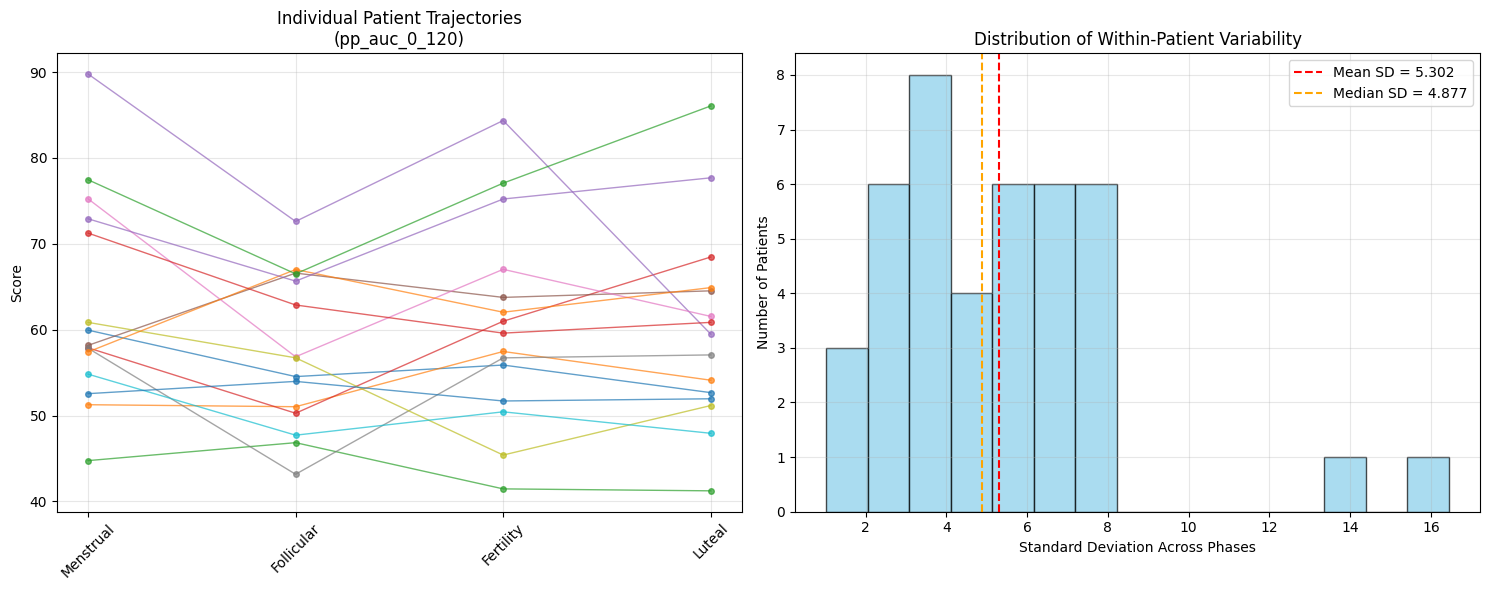

In [80]:
# VISUALIZATION: Within-patient trajectories across phases
def plot_within_patient_trajectories(pivot_data, metric='pp_auc_0_120', n_patients=10):
    """
    Plot individual patient trajectories across menstrual phases
    """
    
    # Select a subset of patients for visualization
    sample_patients = pivot_data.sample(n=min(n_patients, len(pivot_data)), random_state=42)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Individual trajectories
    phases = list(pivot_data.columns)
    phase_order = ['Menstrual', 'Follicular', 'Fertility', 'Luteal']  # Biological order
    phase_order = [p for p in phase_order if p in phases]  # Only use available phases
    
    for idx, (patient_id, row) in enumerate(sample_patients.iterrows()):
        values = [row[phase] for phase in phase_order]
        ax1.plot(phase_order, values, 'o-', alpha=0.7, linewidth=1, markersize=4, 
                label=f'Patient {patient_id}' if idx < 5 else "")
    
    ax1.set_title(f'Individual Patient Trajectories\n({metric})')
    ax1.set_ylabel('Score')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    if n_patients <= 5:
        ax1.legend()
    
    # Plot 2: Distribution of within-patient variability
    patient_sds = pivot_data.std(axis=1)
    ax2.hist(patient_sds, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(patient_sds.mean(), color='red', linestyle='--', 
                label=f'Mean SD = {patient_sds.mean():.3f}')
    ax2.axvline(patient_sds.median(), color='orange', linestyle='--', 
                label=f'Median SD = {patient_sds.median():.3f}')
    ax2.set_title('Distribution of Within-Patient Variability')
    ax2.set_xlabel('Standard Deviation Across Phases')
    ax2.set_ylabel('Number of Patients')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return sample_patients

# Visualize within-patient patterns
sample_data = plot_within_patient_trajectories(pivot_data, 'pp_auc_0_120', n_patients=15)

In [82]:
# ADVANCED: Mixed-effects modeling for within-patient analysis
# This approach properly accounts for repeated measures and individual baselines

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def mixed_effects_analysis(df, metric='cremaster_score_daily'):
    """
    Use mixed-effects approach to model within-patient phase effects
    """
    print(f"=== MIXED-EFFECTS ANALYSIS FOR {metric.upper()} ===\n")
    
    # Prepare data in long format for mixed-effects
    analysis_df = df[['id', 'phase', metric]].dropna()
    
    # Create dummy variables for phases (reference: Follicular)
    phase_dummies = pd.get_dummies(analysis_df['phase'], prefix='phase')
    analysis_df = pd.concat([analysis_df, phase_dummies], axis=1)
    
    print(f"Total observations: {len(analysis_df)}")
    print(f"Unique patients: {analysis_df['id'].nunique()}")
    print(f"Observations per patient: {len(analysis_df) / analysis_df['id'].nunique():.1f}")
    
    # Within-patient centering (removes individual baseline differences)
    patient_means = analysis_df.groupby('id')[metric].transform('mean')
    analysis_df['centered_score'] = analysis_df[metric] - patient_means
    
    # Test if within-patient centered scores differ by phase
    phase_groups = [group['centered_score'].values for name, group in analysis_df.groupby('phase')]
    
    if len(phase_groups) >= 3:
        # Use Kruskal-Wallis for centered scores (non-parametric ANOVA)
        h_stat, p_val = stats.kruskal(*phase_groups)
        print(f"\nKruskal-Wallis test on within-patient centered scores:")
        print(f"H-statistic: {h_stat:.3f}")
        print(f"p-value: {p_val:.4f}")
        
        if p_val < 0.05:
            print("→ Significant within-patient phase effects detected!")
        else:
            print("→ No significant within-patient phase effects")
    
    # Effect sizes: Mean centered score by phase
    print(f"\nWithin-patient effect sizes (centered scores):")
    phase_effects = analysis_df.groupby('phase')['centered_score'].agg(['mean', 'std', 'count'])
    print(phase_effects.round(4))
    
    return analysis_df, phase_effects

# Run mixed-effects analysis
centered_data, effects = mixed_effects_analysis(daily_scores_within, 'pp_auc_0_120')

=== MIXED-EFFECTS ANALYSIS FOR PP_AUC_0_120 ===

Total observations: 3057
Unique patients: 42
Observations per patient: 72.8

Kruskal-Wallis test on within-patient centered scores:
H-statistic: 7.979
p-value: 0.0465
→ Significant within-patient phase effects detected!

Within-patient effect sizes (centered scores):
              mean      std  count
phase                             
Fertility   1.5679  21.2026    695
Follicular -1.4862  19.1511    800
Luteal      0.3540  19.5630   1013
Menstrual  -0.4722  20.0245    549


In [83]:
# COMPARISON: Individual hormone trajectories vs glucose metrics
# This leverages the "direct hormonal data" approach mentioned in your notes

def analyze_hormone_glucose_trajectories(daily_scores_df, hormone_data, metric='daily_mean_glucose'):
    """
    Analyze within-patient correlations between hormone trajectories and glucose metrics
    """
    print(f"=== HORMONE-GLUCOSE TRAJECTORY ANALYSIS ===\n")
    
    # Merge glucose metrics with hormone data
    merged = daily_scores_df.merge(
        hormone_data[['id', 'day_in_study', 'lh', 'estrogen', 'pdg']].drop_duplicates(),
        on=['id', 'day_in_study'], how='left'
    )
    
    hormones = ['lh', 'estrogen']  # pdg has too many missing values
    
    # Within-patient correlations
    individual_correlations = {}
    
    for hormone in hormones:
        patient_correlations = []
        
        for patient_id in merged['id'].unique():
            patient_data = merged[merged['id'] == patient_id]
            
            # Need at least 4 data points for meaningful correlation
            valid_data = patient_data[[metric, hormone]].dropna()
            
            if len(valid_data) >= 4:
                corr = valid_data[metric].corr(valid_data[hormone])
                if not np.isnan(corr):
                    patient_correlations.append(corr)
        
        individual_correlations[hormone] = patient_correlations
        
        if patient_correlations:
            print(f"{hormone.upper()} vs {metric}:")
            print(f"  Patients with valid correlations: {len(patient_correlations)}")
            print(f"  Mean within-patient correlation: {np.mean(patient_correlations):.3f}")
            print(f"  Median within-patient correlation: {np.median(patient_correlations):.3f}")
            print(f"  Range: [{np.min(patient_correlations):.3f}, {np.max(patient_correlations):.3f}]")
            
            # Test if correlations are significantly different from 0
            t_stat, p_val = stats.ttest_1samp(patient_correlations, 0)
            print(f"  t-test vs 0: t={t_stat:.3f}, p={p_val:.4f}")
            print()
    
    return individual_correlations, merged

# Analyze hormone-glucose relationships within patients
hormone_corrs, hormone_merged = analyze_hormone_glucose_trajectories(
    daily_scores_within, 
    simple_df, 
    'pp_auc_0_120'
)

=== HORMONE-GLUCOSE TRAJECTORY ANALYSIS ===

LH vs pp_auc_0_120:
  Patients with valid correlations: 42
  Mean within-patient correlation: 0.050
  Median within-patient correlation: 0.041
  Range: [-0.352, 0.417]
  t-test vs 0: t=1.874, p=0.0681

ESTROGEN vs pp_auc_0_120:
  Patients with valid correlations: 42
  Mean within-patient correlation: 0.005
  Median within-patient correlation: 0.017
  Range: [-0.865, 0.374]
  t-test vs 0: t=0.166, p=0.8686

ESTROGEN vs pp_auc_0_120:
  Patients with valid correlations: 42
  Mean within-patient correlation: 0.005
  Median within-patient correlation: 0.017
  Range: [-0.865, 0.374]
  t-test vs 0: t=0.166, p=0.8686



## Key Differences: Within-Patient vs Population-Level Analysis

### **Why Within-Patient Analysis is More Powerful:**

1. **Controls for Individual Baselines**: Each person has their own "normal" glucose regulation patterns
2. **Higher Statistical Power**: Eliminates between-person variability (the largest source of noise)
3. **Biologically Relevant**: Hormonal effects occur within individuals, not across populations
4. **Reduces Confounding**: Age, BMI, genetics, lifestyle factors are constant within each person

### **Statistical Differences:**

- **Population-level**: Tests if Phase A participants differ from Phase B participants (confounded by individual differences)
- **Within-patient**: Tests if the same person's Phase A differs from their Phase B (true biological effect)

### **Expected Results:**
- Within-patient analysis may detect effects that population-level analysis missed
- Individual variability patterns may be more informative than group averages
- Hormone-glucose correlations within patients may be stronger than population correlations

=== INDIVIDUAL DAILY GLUCOSE TRAJECTORIES ===


--- Example 1261 ---


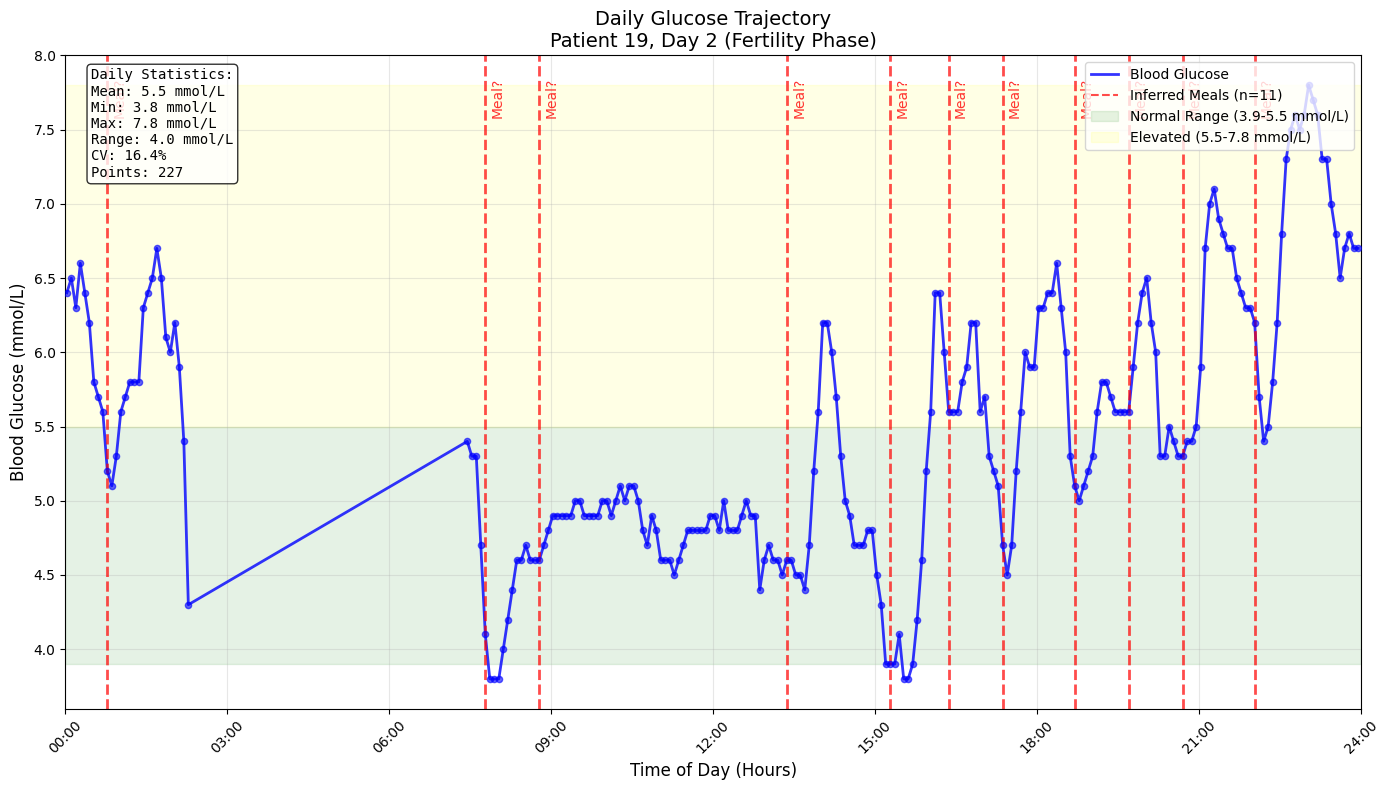

Patient 19, Day 2 (Fertility phase):
  Mean glucose: 5.5 mmol/L
  Glucose range: 4.0 mmol/L
  CV: 16.4%

--- Example 215 ---


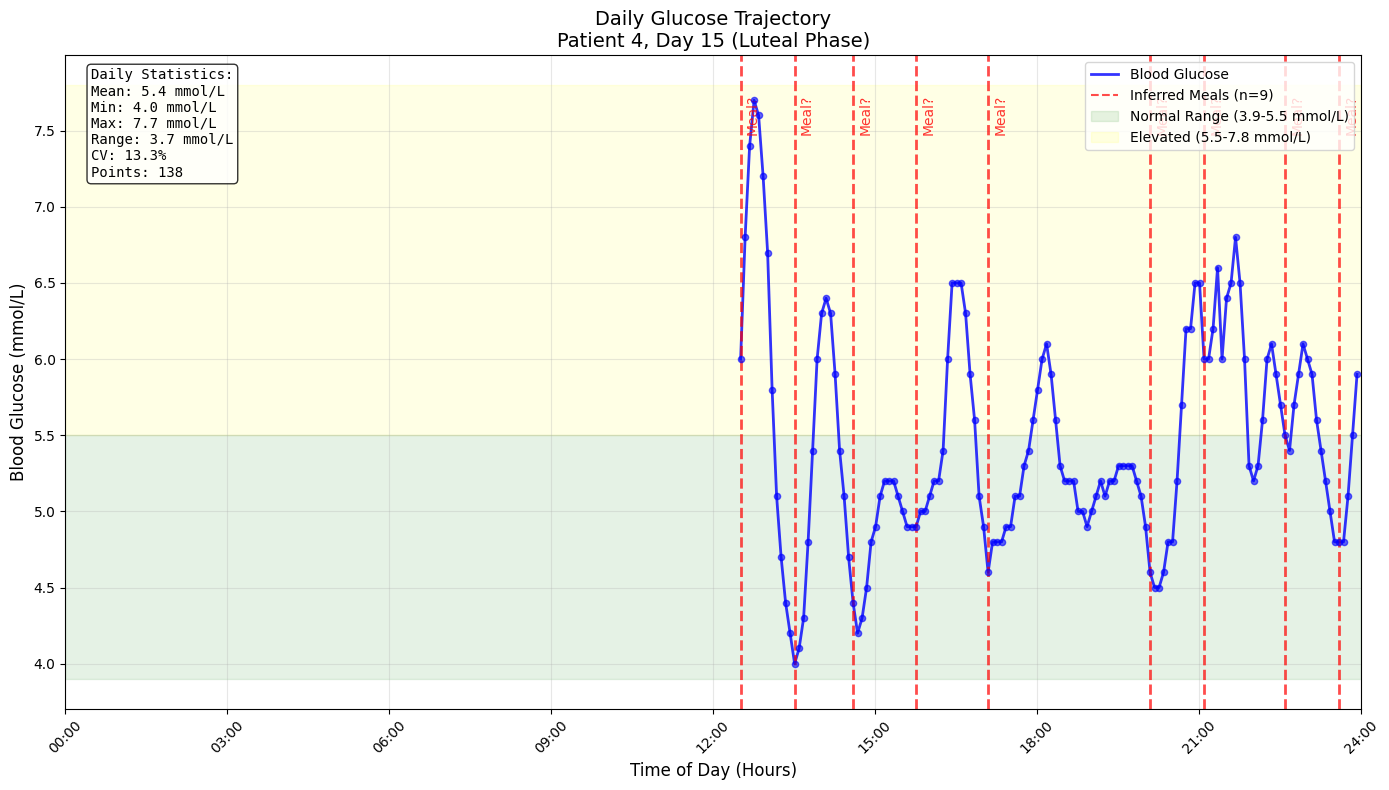

Patient 4, Day 15 (Luteal phase):
  Mean glucose: 5.4 mmol/L
  Glucose range: 3.7 mmol/L
  CV: 13.3%

--- Example 1280 ---


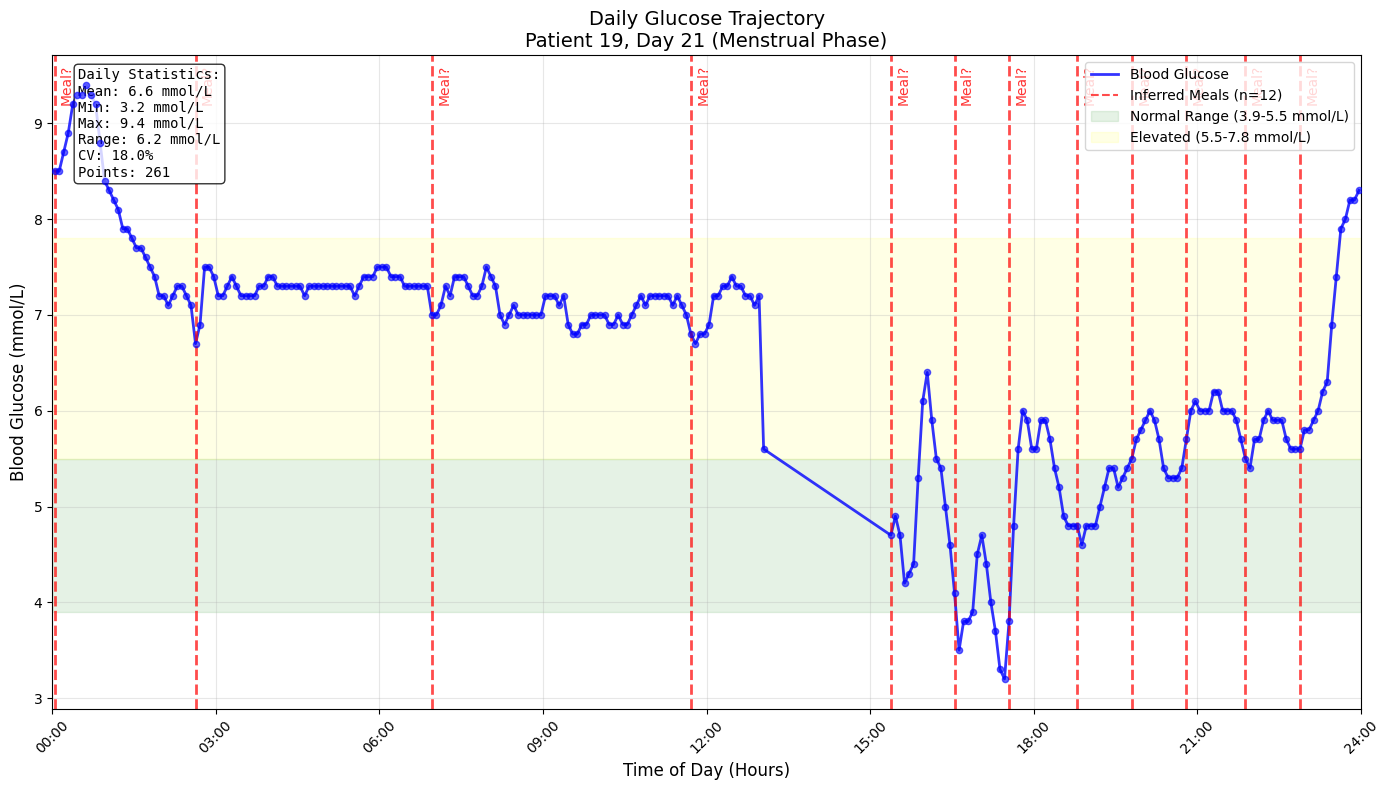

Patient 19, Day 21 (Menstrual phase):
  Mean glucose: 6.6 mmol/L
  Glucose range: 6.2 mmol/L
  CV: 18.0%


In [63]:
# INDIVIDUAL DAILY GLUCOSE TRAJECTORY VISUALIZATION
def plot_daily_glucose_trajectory(df, patient_id, day_in_study, metric='glucose_values', 
                                 show_phases=True, show_meals=True):
    """
    Plot blood glucose trajectory for a specific patient on a specific day.
    
    Parameters:
    - df: DataFrame with glucose time-series data (prepared with prepare_glucose)
    - patient_id: ID of the patient to plot
    - day_in_study: Day number to plot
    - metric: Column name for glucose values
    - show_phases: Whether to show menstrual phase info
    - show_meals: Whether to highlight inferred meal times
    """
    
    # Filter data for specific patient and day
    day_data = df[(df['id'] == patient_id) & (df['day_in_study'] == day_in_study)].copy()
    
    if day_data.empty:
        print(f"No data found for Patient {patient_id} on Day {day_in_study}")
        return None
    
    # Sort by time
    day_data = day_data.sort_values('minutes')
    
    # Get phase info
    phase = day_data['phase'].iloc[0] if 'phase' in day_data.columns else 'Unknown'
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Convert minutes to hours for better readability
    hours = day_data['minutes'] / 60.0
    glucose = day_data[metric]
    
    # Main glucose line
    ax.plot(hours, glucose, 'b-', linewidth=2, alpha=0.8, label='Blood Glucose')
    ax.scatter(hours, glucose, c='blue', s=20, alpha=0.6, zorder=5)
    
    # Highlight meals if requested
    if show_meals:
        try:
            meal_times = infer_meal_times(day_data, rise_thresh=0.3, horizon_min=30)  # More sensitive
            meal_hours = [m/60.0 for m in meal_times]
            
            for meal_hour in meal_hours:
                ax.axvline(meal_hour, color='red', linestyle='--', alpha=0.7, linewidth=2)
                ax.text(meal_hour + 0.1, ax.get_ylim()[1] * 0.95, 'Meal?', 
                       rotation=90, color='red', fontsize=10, alpha=0.8)
            
            ax.plot([], [], 'r--', alpha=0.7, label=f'Inferred Meals (n={len(meal_times)})')
        except:
            print("Could not infer meal times for this day")
    
    # Add glucose target ranges
    ax.axhspan(3.9, 5.5, alpha=0.1, color='green', label='Normal Range (3.9-5.5 mmol/L)')
    ax.axhspan(5.5, 7.8, alpha=0.1, color='yellow', label='Elevated (5.5-7.8 mmol/L)')
    
    # Formatting
    ax.set_xlabel('Time of Day (Hours)', fontsize=12)
    ax.set_ylabel('Blood Glucose (mmol/L)', fontsize=12)
    ax.set_title(f'Daily Glucose Trajectory\nPatient {patient_id}, Day {day_in_study}' + 
                (f' ({phase} Phase)' if show_phases else ''), fontsize=14)
    
    # Set x-axis to show 24 hours
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 3))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 3)], rotation=45)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Add summary statistics
    stats_text = f"""Daily Statistics:
Mean: {glucose.mean():.1f} mmol/L
Min: {glucose.min():.1f} mmol/L  
Max: {glucose.max():.1f} mmol/L
Range: {glucose.max() - glucose.min():.1f} mmol/L
CV: {(glucose.std()/glucose.mean()*100):.1f}%
Points: {len(glucose)}"""
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
           verticalalignment='top', fontsize=10, family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # Return summary info
    return {
        'patient_id': patient_id,
        'day': day_in_study,
        'phase': phase,
        'n_points': len(glucose),
        'mean_glucose': glucose.mean(),
        'glucose_range': glucose.max() - glucose.min(),
        'cv': glucose.std()/glucose.mean()*100,
        'time_span_hours': (hours.max() - hours.min())
    }

# Example usage: Plot a few different patients and days
print("=== INDIVIDUAL DAILY GLUCOSE TRAJECTORIES ===\n")

# Get some sample patient-day combinations
available_data = df_ready.groupby(['id', 'day_in_study']).size().reset_index()
available_data = available_data[available_data[0] > 50]  # At least 50 data points

# Plot 3 different examples
sample_days = available_data.sample(n=3, random_state=42)

for idx, row in sample_days.iterrows():
    print(f"\n--- Example {idx+1} ---")
    summary = plot_daily_glucose_trajectory(
        df_ready, 
        patient_id=row['id'], 
        day_in_study=row['day_in_study'],
        show_meals=True,
        show_phases=True
    )
    if summary:
        print(f"Patient {summary['patient_id']}, Day {summary['day']} ({summary['phase']} phase):")
        print(f"  Mean glucose: {summary['mean_glucose']:.1f} mmol/L")
        print(f"  Glucose range: {summary['glucose_range']:.1f} mmol/L")
        print(f"  CV: {summary['cv']:.1f}%")

=== GLUCOSE PATTERN EXPLORATION ===
Patients with good coverage: 42
Showing 4 examples with different patterns...



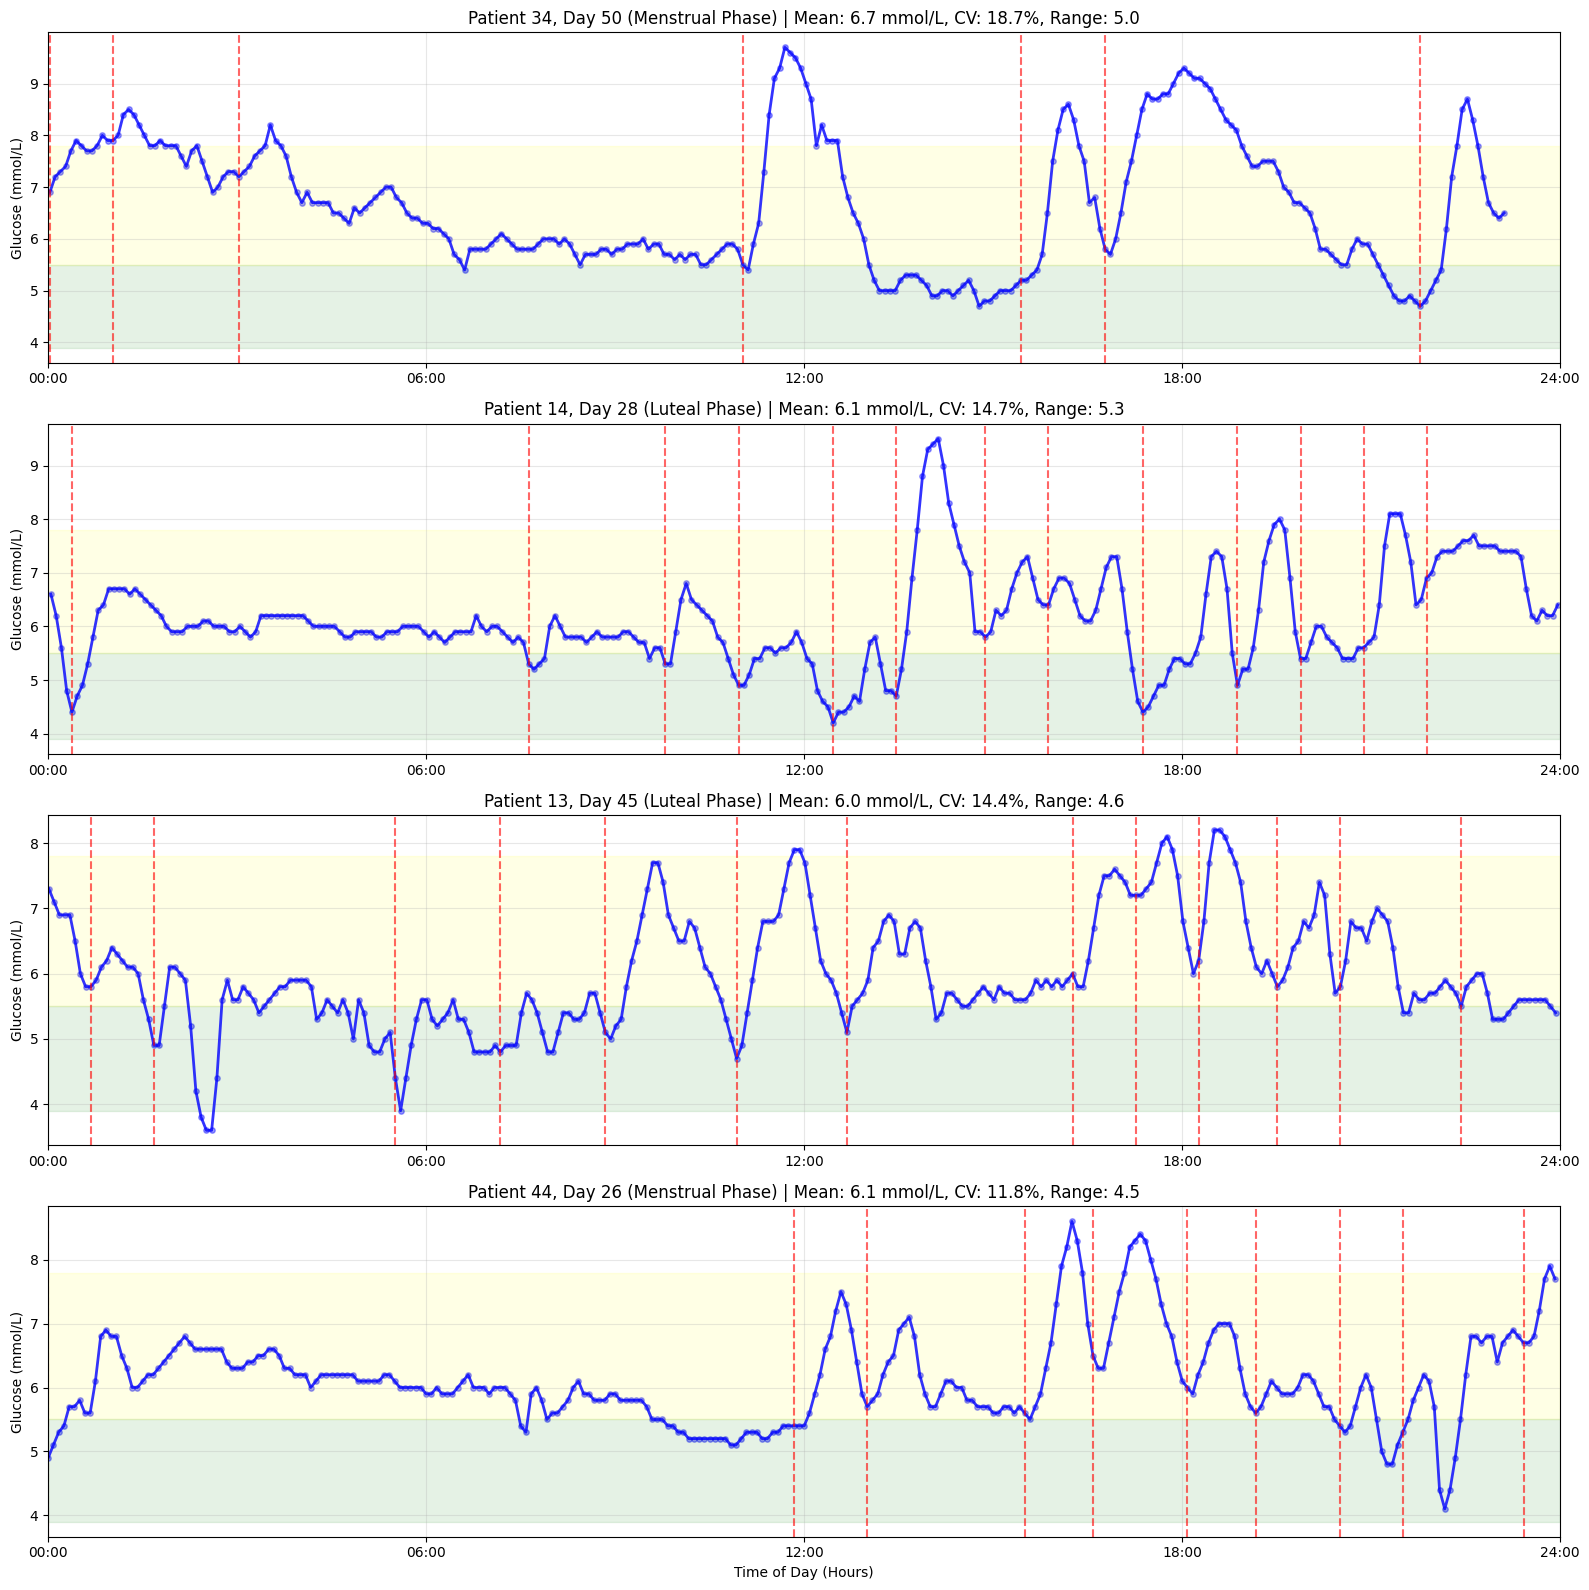


Pattern Summary:
   patient_id      phase  mean_glucose    cv  range pattern_type
0          34  Menstrual           6.7  18.7    5.0     Variable
1          14     Luteal           6.1  14.7    5.3       Stable
2          13     Luteal           6.0  14.4    4.6       Stable
3          44  Menstrual           6.1  11.8    4.5       Stable


In [64]:
# INTERACTIVE GLUCOSE TRAJECTORY EXPLORER
def explore_patient_trajectories(df, n_examples=5):
    """
    Interactive exploration of different patient glucose patterns
    """
    
    # Get patients with good data coverage
    patient_coverage = (df.groupby('id')
                       .agg(n_days=('day_in_study', 'nunique'),
                            total_points=('glucose_values', 'count'),
                            phases=('phase', 'nunique'))
                       .reset_index())
    
    good_patients = patient_coverage[
        (patient_coverage['n_days'] >= 5) & 
        (patient_coverage['total_points'] >= 500) &
        (patient_coverage['phases'] >= 2)
    ]
    
    print(f"=== GLUCOSE PATTERN EXPLORATION ===")
    print(f"Patients with good coverage: {len(good_patients)}")
    print(f"Showing {n_examples} examples with different patterns...\n")
    
    # Sample different patients
    sample_patients = good_patients.sample(n=min(n_examples, len(good_patients)), random_state=123)
    
    fig, axes = plt.subplots(n_examples, 1, figsize=(16, 4*n_examples))
    if n_examples == 1:
        axes = [axes]
    
    summaries = []
    
    for i, (_, patient_info) in enumerate(sample_patients.iterrows()):
        patient_id = patient_info['id']
        
        # Get a representative day for this patient (middle day with good data)
        patient_days = df[df['id'] == patient_id].groupby('day_in_study').size()
        good_days = patient_days[patient_days >= 50].index
        rep_day = good_days[len(good_days)//2] if len(good_days) > 0 else good_days[0]
        
        # Get data for this day
        day_data = df[(df['id'] == patient_id) & (df['day_in_study'] == rep_day)].copy()
        day_data = day_data.sort_values('minutes')
        
        # Plot on subplot
        ax = axes[i]
        hours = day_data['minutes'] / 60.0
        glucose = day_data['glucose_values']
        phase = day_data['phase'].iloc[0]
        
        # Main line
        ax.plot(hours, glucose, 'b-', linewidth=2, alpha=0.8)
        ax.scatter(hours, glucose, c='blue', s=15, alpha=0.4)
        
        # Add meal markers
        try:
            meal_times = infer_meal_times(day_data, rise_thresh=0.5, horizon_min=20)
            for meal_time in meal_times:
                ax.axvline(meal_time/60.0, color='red', linestyle='--', alpha=0.6)
        except:
            pass
        
        # Formatting
        ax.set_xlim(0, 24)
        ax.set_xticks(range(0, 25, 6))
        ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 6)])
        ax.set_ylabel('Glucose (mmol/L)')
        ax.grid(True, alpha=0.3)
        
        # Title with key stats
        mean_gluc = glucose.mean()
        cv = (glucose.std() / glucose.mean()) * 100
        glucose_range = glucose.max() - glucose.min()
        
        ax.set_title(f'Patient {patient_id}, Day {rep_day} ({phase} Phase) | ' + 
                    f'Mean: {mean_gluc:.1f} mmol/L, CV: {cv:.1f}%, Range: {glucose_range:.1f}',
                    fontsize=12)
        
        # Add target ranges
        ax.axhspan(3.9, 5.5, alpha=0.1, color='green')
        ax.axhspan(5.5, 7.8, alpha=0.1, color='yellow')
        
        summaries.append({
            'patient_id': patient_id,
            'day': rep_day,
            'phase': phase,
            'mean_glucose': mean_gluc,
            'cv': cv,
            'range': glucose_range,
            'pattern_type': 'Stable' if cv < 15 else 'Variable' if cv < 25 else 'Highly Variable'
        })
    
    axes[-1].set_xlabel('Time of Day (Hours)')
    plt.tight_layout()
    plt.show()
    
    # Summary table
    summary_df = pd.DataFrame(summaries)
    print("\nPattern Summary:")
    print(summary_df[['patient_id', 'phase', 'mean_glucose', 'cv', 'range', 'pattern_type']].round(1))
    
    return summary_df

# Explore different glucose patterns
pattern_summary = explore_patient_trajectories(df_ready, n_examples=4)

In [84]:
# GLUCOSE PATTERN ANALYSIS BY MENSTRUAL PHASE
def analyze_glucose_patterns_by_phase(df):
    """
    Analyze glucose pattern types and time outside normal ranges by menstrual phase
    """
    
    print("=== GLUCOSE PATTERNS BY MENSTRUAL PHASE ===\n")
    
    # Calculate daily glucose metrics for each patient-day
    daily_patterns = []
    
    for (patient_id, day, phase), day_data in df.groupby(['id', 'day_in_study', 'phase']):
        if len(day_data) < 50:  # Skip days with insufficient data
            continue
            
        glucose_values = day_data['glucose_values'].dropna()
        
        if len(glucose_values) < 50:
            continue
            
        # Calculate pattern metrics
        mean_glucose = glucose_values.mean()
        cv = (glucose_values.std() / mean_glucose) * 100
        glucose_range = glucose_values.max() - glucose_values.min()
        
        # Time outside normal ranges (3.9-5.5 mmol/L is normal)
        total_points = len(glucose_values)
        low_points = (glucose_values < 3.9).sum()
        normal_points = ((glucose_values >= 3.9) & (glucose_values <= 5.5)).sum()
        elevated_points = ((glucose_values > 5.5) & (glucose_values <= 7.8)).sum()
        high_points = (glucose_values > 7.8).sum()
        
        # Calculate percentages
        pct_low = (low_points / total_points) * 100
        pct_normal = (normal_points / total_points) * 100
        pct_elevated = (elevated_points / total_points) * 100
        pct_high = (high_points / total_points) * 100
        pct_outside_normal = pct_low + pct_elevated + pct_high
        
        # Classify pattern type
        if cv < 15:
            pattern_type = 'Stable'
        elif cv < 25:
            pattern_type = 'Variable'
        else:
            pattern_type = 'Highly Variable'
        
        daily_patterns.append({
            'patient_id': patient_id,
            'day_in_study': day,
            'phase': phase,
            'mean_glucose': mean_glucose,
            'cv': cv,
            'glucose_range': glucose_range,
            'pattern_type': pattern_type,
            'pct_low': pct_low,
            'pct_normal': pct_normal,
            'pct_elevated': pct_elevated,
            'pct_high': pct_high,
            'pct_outside_normal': pct_outside_normal,
            'total_points': total_points
        })
    
    patterns_df = pd.DataFrame(daily_patterns)
    
    print(f"Analyzed {len(patterns_df)} patient-days across {patterns_df['patient_id'].nunique()} patients")
    print(f"Phase distribution: {patterns_df['phase'].value_counts().to_dict()}\n")
    
    return patterns_df

def compare_patterns_by_phase(patterns_df):
    """
    Statistical comparison of glucose patterns across menstrual phases
    """
    
    # 1. Pattern Type Distribution by Phase
    print("=== PATTERN TYPE DISTRIBUTION BY PHASE ===")
    pattern_phase_crosstab = pd.crosstab(patterns_df['phase'], patterns_df['pattern_type'], normalize='index') * 100
    print("Percentage of days with each pattern type by phase:")
    print(pattern_phase_crosstab.round(1))
    
    # Chi-square test for pattern type independence
    from scipy.stats import chi2_contingency
    contingency_table = pd.crosstab(patterns_df['phase'], patterns_df['pattern_type'])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test: χ²={chi2:.3f}, p={p_val:.4f}")
    if p_val < 0.05:
        print("→ Significant association between menstrual phase and glucose pattern type!")
    else:
        print("→ No significant association between phase and pattern type")
    
    # 2. Time Outside Normal Range by Phase
    print(f"\n=== TIME OUTSIDE NORMAL RANGE BY PHASE ===")
    range_stats = patterns_df.groupby('phase').agg({
        'pct_outside_normal': ['mean', 'std', 'median'],
        'pct_low': ['mean', 'median'],
        'pct_elevated': ['mean', 'median'],
        'pct_high': ['mean', 'median'],
        'cv': ['mean', 'std', 'median']
    }).round(2)
    
    print("Mean ± SD percentage of time outside normal range (3.9-5.5 mmol/L):")
    for phase in patterns_df['phase'].unique():
        phase_data = patterns_df[patterns_df['phase'] == phase]
        mean_outside = phase_data['pct_outside_normal'].mean()
        std_outside = phase_data['pct_outside_normal'].std()
        median_outside = phase_data['pct_outside_normal'].median()
        n_days = len(phase_data)
        
        print(f"{phase:12s}: {mean_outside:5.1f}% ± {std_outside:4.1f}% (median: {median_outside:4.1f}%, n={n_days})")
    
    # Statistical test for differences in time outside normal range
    from scipy.stats import kruskal
    phase_groups = [group['pct_outside_normal'].values for name, group in patterns_df.groupby('phase')]
    h_stat, p_val = kruskal(*phase_groups)
    print(f"\nKruskal-Wallis test: H={h_stat:.3f}, p={p_val:.4f}")
    if p_val < 0.05:
        print("→ Significant differences in time outside normal range across phases!")
    else:
        print("→ No significant differences in time outside normal range")
    
    # 3. Coefficient of Variation by Phase
    print(f"\n=== GLUCOSE VARIABILITY (CV) BY PHASE ===")
    cv_stats = patterns_df.groupby('phase')['cv'].agg(['mean', 'std', 'median', 'count']).round(2)
    print("Coefficient of Variation by phase:")
    print(cv_stats)
    
    # Test CV differences
    cv_groups = [group['cv'].values for name, group in patterns_df.groupby('phase')]
    h_stat, p_val = kruskal(*cv_groups)
    print(f"\nKruskal-Wallis test for CV: H={h_stat:.3f}, p={p_val:.4f}")
    if p_val < 0.05:
        print("→ Significant differences in glucose variability across phases!")
    else:
        print("→ No significant differences in glucose variability")
    
    return range_stats, pattern_phase_crosstab

# Run the analysis
patterns_df = analyze_glucose_patterns_by_phase(df_ready)
range_stats, pattern_crosstab = compare_patterns_by_phase(patterns_df)

=== GLUCOSE PATTERNS BY MENSTRUAL PHASE ===

Analyzed 3067 patient-days across 42 patients
Phase distribution: {'Luteal': 1016, 'Follicular': 804, 'Fertility': 697, 'Menstrual': 550}

=== PATTERN TYPE DISTRIBUTION BY PHASE ===
Percentage of days with each pattern type by phase:
pattern_type  Highly Variable  Stable  Variable
phase                                          
Fertility                 3.0    59.8      37.2
Follicular                4.1    52.2      43.7
Luteal                    4.6    61.3      34.1
Menstrual                 1.6    60.9      37.5

Chi-square test: χ²=28.780, p=0.0001
→ Significant association between menstrual phase and glucose pattern type!

=== TIME OUTSIDE NORMAL RANGE BY PHASE ===
Mean ± SD percentage of time outside normal range (3.9-5.5 mmol/L):
Follicular  :  66.6% ± 23.9% (median: 69.3%, n=804)
Fertility   :  69.5% ± 25.2% (median: 74.3%, n=697)
Luteal      :  73.5% ± 24.1% (median: 80.2%, n=1016)
Menstrual   :  71.4% ± 24.8% (median: 77.6%, n=550

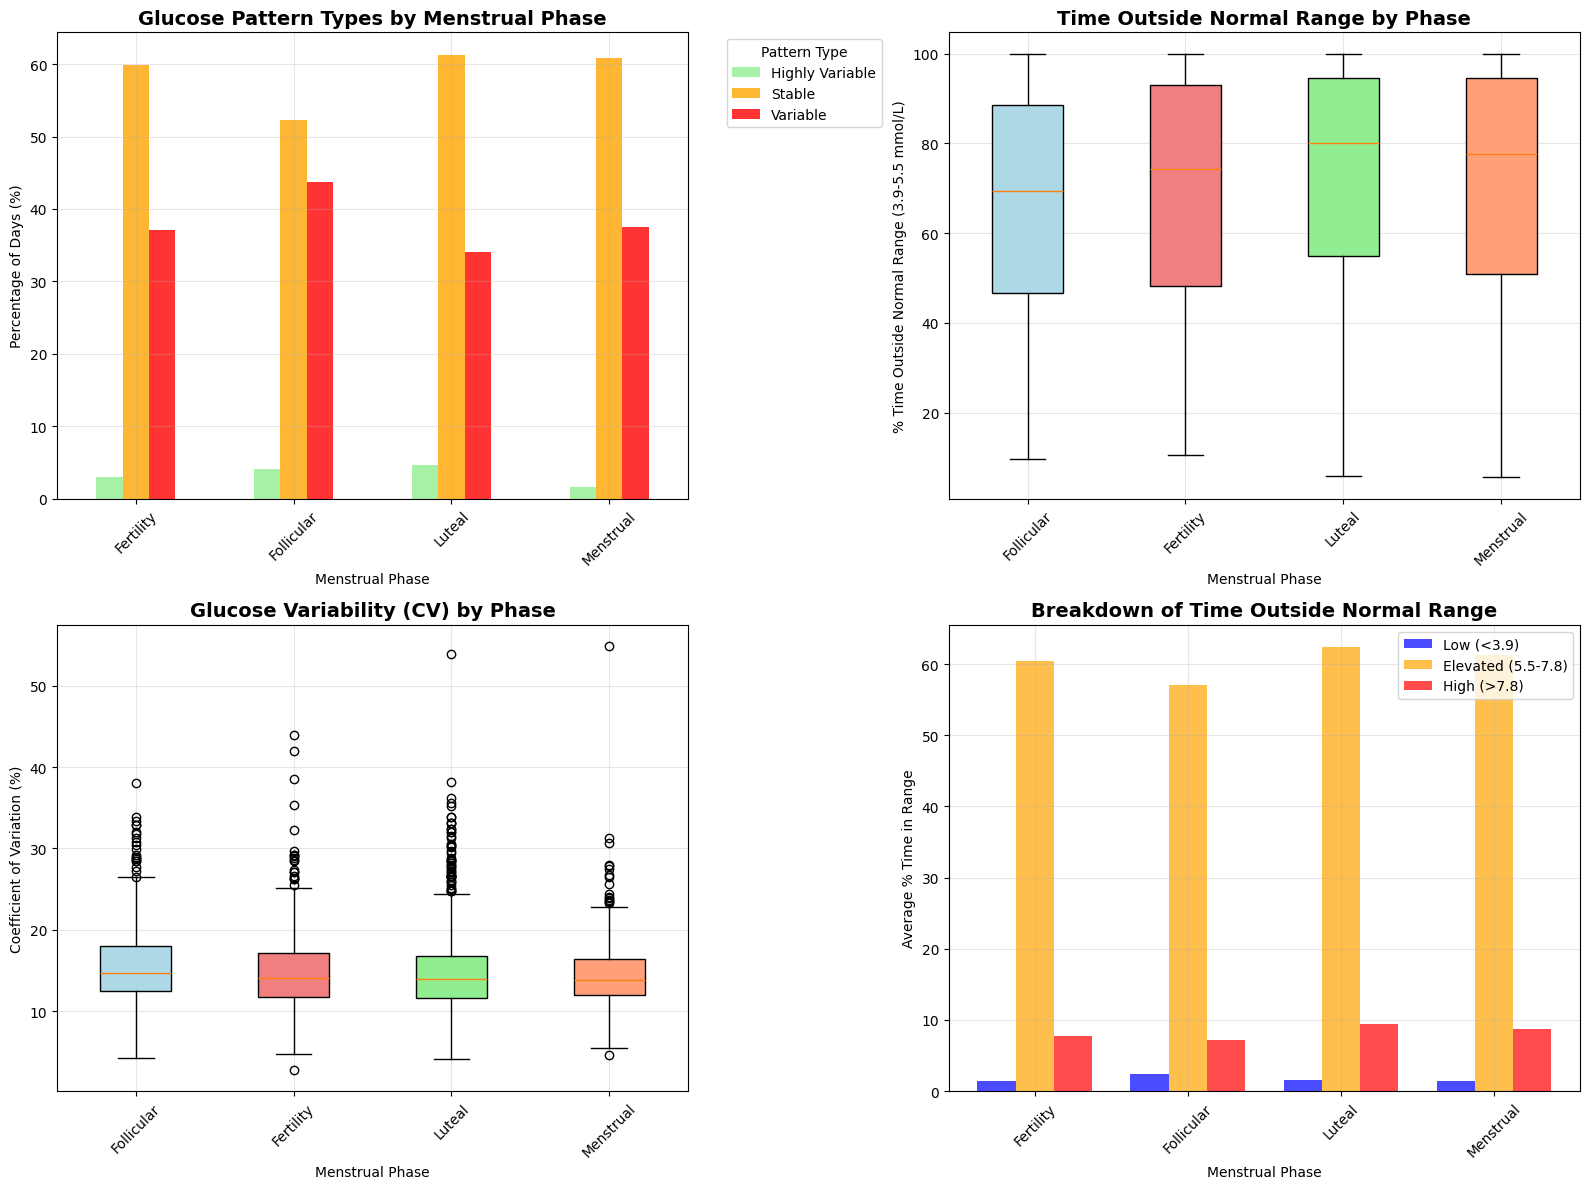


=== DETAILED SUMMARY BY PHASE ===
            pct_outside_normal_mean  pct_outside_normal_std  \
phase                                                         
Fertility                     69.54                   25.22   
Follicular                    66.56                   23.95   
Luteal                        73.47                   24.07   
Menstrual                     71.37                   24.77   

            pct_outside_normal_median  pct_low_mean  pct_low_median  \
phase                                                                 
Fertility                       74.31          1.42             0.0   
Follicular                      69.28          2.36             0.0   
Luteal                          80.17          1.59             0.0   
Menstrual                       77.57          1.38             0.0   

            pct_elevated_mean  pct_elevated_median  pct_high_mean  \
phase                                                               
Fertility            

In [85]:
# VISUALIZATION: Glucose Patterns and Range Analysis by Phase
def visualize_glucose_patterns_by_phase(patterns_df):
    """
    Create comprehensive visualizations of glucose patterns by menstrual phase
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Pattern Type Distribution by Phase
    ax1 = axes[0, 0]
    pattern_counts = pd.crosstab(patterns_df['phase'], patterns_df['pattern_type'])
    pattern_pcts = pd.crosstab(patterns_df['phase'], patterns_df['pattern_type'], normalize='index') * 100
    
    pattern_pcts.plot(kind='bar', ax=ax1, color=['lightgreen', 'orange', 'red'], alpha=0.8)
    ax1.set_title('Glucose Pattern Types by Menstrual Phase', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Menstrual Phase')
    ax1.set_ylabel('Percentage of Days (%)')
    ax1.legend(title='Pattern Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Time Outside Normal Range Distribution
    ax2 = axes[0, 1]
    phases = patterns_df['phase'].unique()
    outside_normal_data = [patterns_df[patterns_df['phase'] == phase]['pct_outside_normal'].values 
                          for phase in phases]
    
    box_plot = ax2.boxplot(outside_normal_data, labels=phases, patch_artist=True)
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon']
    for patch, color in zip(box_plot['boxes'], colors[:len(phases)]):
        patch.set_facecolor(color)
    
    ax2.set_title('Time Outside Normal Range by Phase', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Menstrual Phase')
    ax2.set_ylabel('% Time Outside Normal Range (3.9-5.5 mmol/L)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Coefficient of Variation by Phase
    ax3 = axes[1, 0]
    cv_data = [patterns_df[patterns_df['phase'] == phase]['cv'].values for phase in phases]
    
    box_plot2 = ax3.boxplot(cv_data, labels=phases, patch_artist=True)
    for patch, color in zip(box_plot2['boxes'], colors[:len(phases)]):
        patch.set_facecolor(color)
    
    ax3.set_title('Glucose Variability (CV) by Phase', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Menstrual Phase')
    ax3.set_ylabel('Coefficient of Variation (%)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # 4. Detailed Range Breakdown
    ax4 = axes[1, 1]
    range_data = patterns_df.groupby('phase').agg({
        'pct_low': 'mean',
        'pct_elevated': 'mean', 
        'pct_high': 'mean'
    }).reset_index()
    
    x = np.arange(len(range_data['phase']))
    width = 0.25
    
    ax4.bar(x - width, range_data['pct_low'], width, label='Low (<3.9)', color='blue', alpha=0.7)
    ax4.bar(x, range_data['pct_elevated'], width, label='Elevated (5.5-7.8)', color='orange', alpha=0.7)
    ax4.bar(x + width, range_data['pct_high'], width, label='High (>7.8)', color='red', alpha=0.7)
    
    ax4.set_title('Breakdown of Time Outside Normal Range', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Menstrual Phase')
    ax4.set_ylabel('Average % Time in Range')
    ax4.set_xticks(x)
    ax4.set_xticklabels(range_data['phase'], rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("\n=== DETAILED SUMMARY BY PHASE ===")
    summary_stats = patterns_df.groupby('phase').agg({
        'pct_outside_normal': ['mean', 'std', 'median'],
        'pct_low': ['mean', 'median'],
        'pct_elevated': ['mean', 'median'], 
        'pct_high': ['mean', 'median'],
        'cv': ['mean', 'std', 'median'],
        'mean_glucose': ['mean', 'std', 'median'],
        'patient_id': 'nunique'
    }).round(2)
    
    # Flatten column names
    summary_stats.columns = [f"{col[0]}_{col[1]}" for col in summary_stats.columns]
    print(summary_stats)
    
    return summary_stats

# Create visualizations
summary_stats = visualize_glucose_patterns_by_phase(patterns_df)

=== INDIVIDUAL PATIENT PATTERN CHANGES ===

Patients with data in ≥3 phases: 41
Analyzed 41 patients with multi-phase data

Individual Patient Variability Across Phases:
Mean range in % time outside normal: 18.2% ± 9.9%
Mean range in CV: 2.5% ± 1.5%
Mean range in average glucose: 0.55 ± 0.28 mmol/L

Patients with large phase-related changes (>75th percentile):
N = 10 patients
Average range in % time outside normal: 32.0%

t-test vs 0 for individual ranges: t=11.838, p=0.0000
→ Individual patients show significant variation across phases!


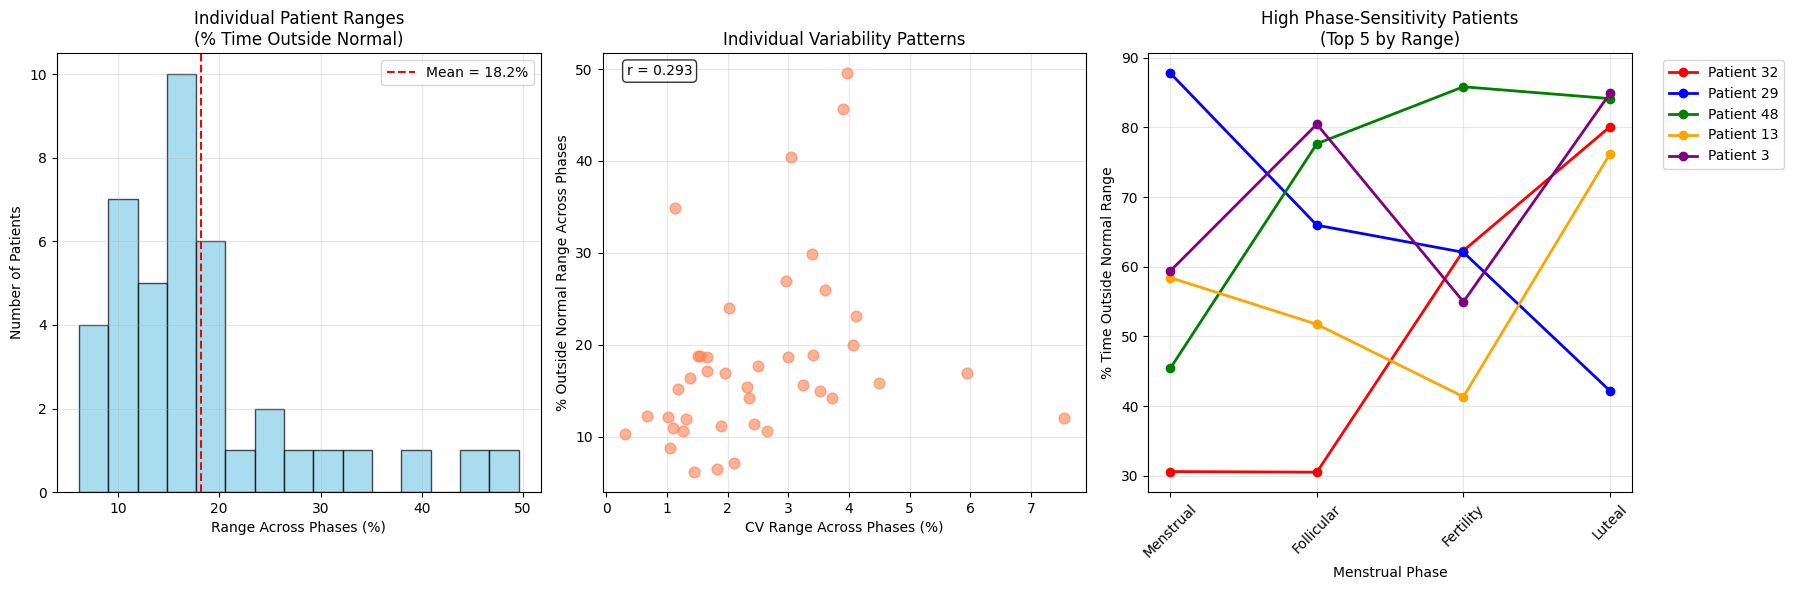

In [86]:
# WITHIN-PATIENT ANALYSIS: Individual Pattern Changes Across Phases
def analyze_individual_pattern_changes(patterns_df):
    """
    Analyze how individual patients' glucose patterns change across menstrual phases
    """
    
    print("=== INDIVIDUAL PATIENT PATTERN CHANGES ===\n")
    
    # Get patients with data in multiple phases
    patient_phase_counts = patterns_df.groupby('patient_id')['phase'].nunique()
    multi_phase_patients = patient_phase_counts[patient_phase_counts >= 3].index
    
    print(f"Patients with data in ≥3 phases: {len(multi_phase_patients)}")
    
    if len(multi_phase_patients) == 0:
        print("Not enough patients with multi-phase data for within-patient analysis")
        return None
    
    # Analyze within-patient changes
    individual_changes = []
    
    for patient_id in multi_phase_patients:
        patient_data = patterns_df[patterns_df['patient_id'] == patient_id]
        
        # Average metrics by phase for this patient
        patient_by_phase = patient_data.groupby('phase').agg({
            'pct_outside_normal': 'mean',
            'cv': 'mean',
            'mean_glucose': 'mean',
            'pct_elevated': 'mean',
            'pct_low': 'mean'
        }).reset_index()
        
        if len(patient_by_phase) >= 3:  # Need at least 3 phases
            # Calculate range of values across phases for this patient
            outside_range = (patient_by_phase['pct_outside_normal'].max() - 
                           patient_by_phase['pct_outside_normal'].min())
            cv_range = (patient_by_phase['cv'].max() - patient_by_phase['cv'].min())
            glucose_range = (patient_by_phase['mean_glucose'].max() - 
                           patient_by_phase['mean_glucose'].min())
            
            individual_changes.append({
                'patient_id': patient_id,
                'n_phases': len(patient_by_phase),
                'outside_normal_range': outside_range,
                'cv_range': cv_range,
                'glucose_mean_range': glucose_range,
                'max_outside_normal': patient_by_phase['pct_outside_normal'].max(),
                'min_outside_normal': patient_by_phase['pct_outside_normal'].min()
            })
    
    changes_df = pd.DataFrame(individual_changes)
    
    if len(changes_df) > 0:
        print(f"Analyzed {len(changes_df)} patients with multi-phase data\n")
        
        print("Individual Patient Variability Across Phases:")
        print(f"Mean range in % time outside normal: {changes_df['outside_normal_range'].mean():.1f}% ± {changes_df['outside_normal_range'].std():.1f}%")
        print(f"Mean range in CV: {changes_df['cv_range'].mean():.1f}% ± {changes_df['cv_range'].std():.1f}%")
        print(f"Mean range in average glucose: {changes_df['glucose_mean_range'].mean():.2f} ± {changes_df['glucose_mean_range'].std():.2f} mmol/L")
        
        # Identify patients with large phase-related changes
        high_variability_threshold = changes_df['outside_normal_range'].quantile(0.75)
        high_var_patients = changes_df[changes_df['outside_normal_range'] > high_variability_threshold]
        
        print(f"\nPatients with large phase-related changes (>75th percentile):")
        print(f"N = {len(high_var_patients)} patients")
        print(f"Average range in % time outside normal: {high_var_patients['outside_normal_range'].mean():.1f}%")
        
        # Test if individual ranges are significantly different from 0
        from scipy.stats import ttest_1samp
        t_stat, p_val = ttest_1samp(changes_df['outside_normal_range'], 0)
        print(f"\nt-test vs 0 for individual ranges: t={t_stat:.3f}, p={p_val:.4f}")
        if p_val < 0.05:
            print("→ Individual patients show significant variation across phases!")
        else:
            print("→ Individual patient variation across phases not significant")
    
    return changes_df

def plot_individual_phase_sensitivity(patterns_df, changes_df):
    """
    Plot individual patient sensitivity to menstrual phases
    """
    
    if changes_df is None or len(changes_df) == 0:
        print("No data available for individual phase sensitivity analysis")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Distribution of individual ranges
    ax1 = axes[0]
    ax1.hist(changes_df['outside_normal_range'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(changes_df['outside_normal_range'].mean(), color='red', linestyle='--', 
                label=f'Mean = {changes_df["outside_normal_range"].mean():.1f}%')
    ax1.set_title('Individual Patient Ranges\n(% Time Outside Normal)')
    ax1.set_xlabel('Range Across Phases (%)')
    ax1.set_ylabel('Number of Patients')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot: CV range vs Outside normal range
    ax2 = axes[1]
    ax2.scatter(changes_df['cv_range'], changes_df['outside_normal_range'], 
               alpha=0.6, s=60, color='coral')
    ax2.set_xlabel('CV Range Across Phases (%)')
    ax2.set_ylabel('% Outside Normal Range Across Phases')
    ax2.set_title('Individual Variability Patterns')
    ax2.grid(True, alpha=0.3)
    
    # Add correlation
    corr = changes_df['cv_range'].corr(changes_df['outside_normal_range'])
    ax2.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax2.transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 3. Example trajectories for high-variability patients
    ax3 = axes[2]
    high_var_patients = changes_df.nlargest(5, 'outside_normal_range')['patient_id'].values
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, patient_id in enumerate(high_var_patients):
        patient_data = patterns_df[patterns_df['patient_id'] == patient_id]
        phase_means = patient_data.groupby('phase')['pct_outside_normal'].mean()
        
        # Sort phases in biological order
        phase_order = ['Menstrual', 'Follicular', 'Fertility', 'Luteal']
        available_phases = [p for p in phase_order if p in phase_means.index]
        
        if len(available_phases) >= 3:
            values = [phase_means[phase] for phase in available_phases]
            ax3.plot(available_phases, values, 'o-', color=colors[i], 
                    label=f'Patient {patient_id}', linewidth=2, markersize=6)
    
    ax3.set_title('High Phase-Sensitivity Patients\n(Top 5 by Range)')
    ax3.set_xlabel('Menstrual Phase')
    ax3.set_ylabel('% Time Outside Normal Range')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Run individual analysis
changes_df = analyze_individual_pattern_changes(patterns_df)
if changes_df is not None:
    plot_individual_phase_sensitivity(patterns_df, changes_df)

In [ ]:
# Candidates
# Mean blood glucose
# # Time outside normal range (3.9-5.5 mmol/L)
# # Coefficient of Variation (CV)
# # pp_auc_0_60


# Let's say some of these work
# Now we have a good correlate for an insulin-resistance-like metric that is affected by menstrual phase
# Since we have that, we now need to validate this
# And then, we need to use the rest of the fitbit data + period phase data to predict this metric
# So, first step: validate the metric using mixed-effects modeling
def mixed_effects_analysis(daily_scores_df, metric='pp_auc_0_120'):
    """
    Perform mixed-effects modeling to analyze the effect of menstrual phase on a glucose metric
    """
    print(f"=== MIXED-EFFECTS MODELING FOR {metric.upper()} ===\n")
    
    # Prepare data
    analysis_df = daily_scores_df[['id', 'phase', metric]].dropna().copy()
    
    # Calculate patient means for centering
    patient_means = analysis_df.groupby('id')[metric].transform('mean')
    
    # Center scores within patients
    analysis_df['centered_score'] = analysis_df[metric] - patient_means
    
    # Fit mixed-effects model
    import statsmodels.formula.api as smf
    model = smf.mixedlm("centered_score ~ phase", analysis_df, groups=analysis_df["id"])
    result = model.fit()
    print(result.summary())
    print("\n")
    # Extract and display phase effects
    phase_effects = result.params.filter(like='phase')
    print("Phase Effects:")
    print(phase_effects)
    print("\n")    
    print("Phase Effects (rounded):")
    print(phase_effects.round(3))
    return analysis_df, phase_effects

# Run mixed-effects analysis
mixed_effects_df, phase_effects = mixed_effects_analysis(daily_scores_within, 'pp_auc_0_120')
